In [1]:
from settings import *

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
ppfeatures = [
    "vesselId", 
    "time",
    # 'time_diff',
    'cog',
    'sog',
    'rot',
    'heading',
    # 'navstat',
    # 'etaRaw',
    'latitude',
    'longitude',
]

In [4]:
input_features = [
    "vesselId", 
    "time",
    'time_diff',
    'cog',
    'sog',
    'rot',
    'heading',
    # 'navstat',
    # 'etaRaw',
    'latitude',
    'longitude',
]

output_features = [
    "vesselId", 
    "time",
    'time_diff',
    'cog',
    'sog',
    'rot',
    'heading',
    # 'navstat',
    # 'etaRaw',
    'latitude',
    'longitude',
]

In [5]:
ais_train = pd.read_csv(AIS_TRAIN, sep='|')
ais_train['time'] = pd.to_datetime(ais_train['time'])

In [6]:
# vessels = pd.read_csv(VESSELS, sep='|')
# vessels.head()

In [7]:
# pd.read_csv(SCHEDULES_TO_MAY_2024, sep="|")

In [8]:
ais_test = pd.read_csv(AIS_TEST, sep=",")
ais_test['time'] = pd.to_datetime(ais_test['time'])

In [9]:
# ais_test.head()

In [10]:
len(ais_test["vesselId"].unique())

215

In [11]:

# def make_features(df: pd.DataFrame) -> pd.DataFrame:
#     raw = df.copy()

#     # time_diff: difference of time since last measure
#     raw['time'] = pd.to_datetime(raw['time'])
#     raw['time_diff'] = raw.sort_values(by=['vesselId', 'time']).groupby("vesselId")['time'].diff()
    
    
#     return raw

In [12]:
# ais_tr = make_features(ais_train)

In [13]:
# te.sort_values(by=["vesselId", "time"])

In [14]:
ais_train["portId"].isna().sum()

1615

In [15]:
ais_train

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,portId
0,2024-01-01 00:00:25,284.0,0.7,0,88,0,01-09 23:00,-34.74370,-57.85130,61e9f3a8b937134a3c4bfdf7,61d371c43aeaecc07011a37f
1,2024-01-01 00:00:36,109.6,0.0,-6,347,1,12-29 20:00,8.89440,-79.47939,61e9f3d4b937134a3c4bff1f,634c4de270937fc01c3a7689
2,2024-01-01 00:01:45,111.0,11.0,0,112,0,01-02 09:00,39.19065,-76.47567,61e9f436b937134a3c4c0131,61d3847bb7b7526e1adf3d19
3,2024-01-01 00:03:11,96.4,0.0,0,142,1,12-31 20:00,-34.41189,151.02067,61e9f3b4b937134a3c4bfe77,61d36f770a1807568ff9a126
4,2024-01-01 00:03:51,214.0,19.7,0,215,0,01-25 12:00,35.88379,-5.91636,61e9f41bb937134a3c4c0087,634c4de270937fc01c3a74f3
...,...,...,...,...,...,...,...,...,...,...,...
1522060,2024-05-07 23:59:07,359.1,13.4,0,1,0,05-08 05:00,52.19131,-5.82223,clh6aqawa0002gh0zypfa5dut,634c4de270937fc01c3a7417
1522061,2024-05-07 23:59:08,12.3,17.1,0,13,0,05-10 03:00,38.96142,-12.00502,61e9f3aeb937134a3c4bfe43,634c4de270937fc01c3a76a1
1522062,2024-05-07 23:59:08,269.8,14.9,-1,270,0,05-15 23:00,49.71372,-5.22042,61e9f43db937134a3c4c0169,634c4de270937fc01c3a787b
1522063,2024-05-07 23:59:08,8.0,18.7,0,6,0,05-08 12:45,38.27895,10.78280,61e9f469b937134a3c4c029b,61d3781293c6feb83e5eb73b


In [16]:
# CREATE time_diff AND MAKE IT IN SECONDS

train_vessel_id_time = ais_train[ppfeatures].copy()
train_vessel_id_time["split"] = "train"
train_vessel_id_time["ID"] = train_vessel_id_time.index

test_vessel_id_time = ais_test[["ID", "vesselId", "time" ]].copy()
test_vessel_id_time["split"] = "test"
ais_data = pd.concat([train_vessel_id_time, test_vessel_id_time], ignore_index=True)

# arrival time diff (from etaRaw)
# 
ais_data['time_diff'] = (
    ais_data
    .sort_values(by=['time'])
    .groupby("vesselId")['time']
    .diff()
    .dropna()
    .dt.total_seconds()
    .astype(int)
    .shift(-1)
)


def update_split_column(group: pd.Series) -> pd.Series:
    if group.name in ais_test["vesselId"].unique():
        group.iloc[-1] = "both"
    return group

df_temp = ais_data.copy()

ser_temp = pd.Series(
    df_temp[df_temp["split"]=="train"]
    .sort_values(by="time")
    .groupby("vesselId")["split"]
    .apply(update_split_column)
    .reset_index(drop=True)
)
ser_temp.index = df_temp[df_temp["split"]=="train"].sort_values(["vesselId", "time"]).index

ais_data.loc[ser_temp.index, "split"] = ser_temp

In [17]:
ais_data.describe()

,time,cog,sog,rot,heading,latitude,longitude,ID,time_diff
count,1573804,1.522065e+06,1.522065e+06,1.522065e+06,1.522065e+06,1.522065e+06,1.522065e+06,1.573804e+06,1.573115e+06
mean,2024-03-08 06:56:40.475442944,1.782494e+02,6.331703e+00,5.054561e-01,1.762737e+02,3.658497e+01,1.153646e+01,7.368634e+05,4.571780e+03
min,2024-01-01 00:00:25,0.000000e+00,0.000000e+00,-1.270000e+02,0.000000e+00,-4.753287e+01,-1.675409e+02,0.000000e+00,2.000000e+00
25%,2024-02-04 06:34:57,7.820000e+01,0.000000e+00,0.000000e+00,7.500000e+01,3.451683e+01,-5.212810e+00,3.417118e+05,1.146000e+03
50%,2024-03-09 12:33:56.500000,1.838000e+02,5.000000e-01,0.000000e+00,1.800000e+02,4.223370e+01,4.234350e+00,7.351625e+05,1.238000e+03
75%,2024-04-10 12:15:27.249999872,2.690000e+02,1.410000e+01,0.000000e+00,2.650000e+02,5.135197e+01,1.883715e+01,1.128613e+06,1.261000e+03
max,2024-05-12 23:59:58,3.600000e+02,1.023000e+02,1.280000e+02,5.110000e+02,7.055720e+01,1.788054e+02,1.522064e+06,5.923375e+06
std,NaN,1.076785e+02,7.539364e+00,1.760916e+01,1.070860e+02,2.290488e+01,6.871572e+01,4.515542e+05,5.228083e+04


In [18]:
data_train = ais_data[(ais_data["split"]=="train")|(ais_data["split"]=="both")]
data_test = ais_data[(ais_data["split"]=="test")|(ais_data["split"]=="both")]

In [19]:
scaled_features = [
    'time_diff',
    'cog',
    'sog',
    'rot',
    'heading',
    # 'navstat',
    # 'etaRaw',
    'latitude',
    'longitude',
]
# scaled_features_y = [
#     'time_diff',
#     'cog',
#     'sog',
#     'rot',
#     'heading',
#     # 'navstat',
#     # 'etaRaw',
#     'latitude',
#     'longitude',
# ]

In [20]:
scaler = StandardScaler()

In [21]:
data_train = data_train.dropna(subset="time_diff")

In [22]:
X = data_train.sort_values(["vesselId", "time"]).iloc[:-1][input_features]
y = data_train.sort_values(["vesselId", "time"]).iloc[1:][output_features]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=False)

In [24]:
X_train_scaled = X_train.copy()
X_train_scaled[scaled_features] = scaler.fit_transform(X_train_scaled[scaled_features])

y_train_scaled = y_train.copy()
y_train_scaled[scaled_features] = scaler.transform(y_train_scaled[scaled_features])

In [25]:
X_test_scaled = X_test.copy()
X_test_scaled[scaled_features] = scaler.transform(X_test_scaled[scaled_features])

y_test_scaled = y_test.copy()
y_test_scaled[scaled_features] = scaler.transform(y_test_scaled[scaled_features])

In [26]:
# X_train = X_train.sort_values(["time", "vesselId"])
# y_train = y_train.sort_values(["time", "vesselId"])
# X_test = X_test.sort_values(["time", "vesselId"])
# y_test = y_test.sort_values(["time", "vesselId"])

In [27]:
import xgboost as xgb

from sklearn import preprocessing

from sklearn.model_selection import GridSearchCV

In [28]:
params = {
    'n_estimators': 5000,
    'gamma': 0.5,
    'subsample': 0.6,
    'n_estimators': 5000,
    'min_child_weight':  15,
    'colsample_bytree': 0.8,
    'max_depth': 4,
    'eta':  0.005,
    'refresh_leaf': 1,
}

In [29]:
param_grid = {
    'n_estimators': [5000, 10_000],
    'gamma': [0.5,],
    'subsample': [0.6,],
    'min_child_weight':  [15, 20],
    'colsample_bytree': [0.8,],
    'max_depth': [4, 10],
    'eta':  [0.005,],
    'refresh_leaf': [1,],

}

In [29]:
X_train = X_train_scaled[scaled_features]
y_train = y_train_scaled[scaled_features]
X_test = X_test_scaled[scaled_features]
y_test = y_test_scaled[scaled_features]

In [ ]:
xgb_model = xgb.XGBRegressor(**params)

grid_search = GridSearchCV(xgb_model, param_grid=param_grid)
grid_search.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)]
)
xgb_model = grid_search.best_estimator_
print(grid_search.best_params_)

In [30]:
# xgb_model.fit(
#     X_train, y_train,
#     eval_set=[(X_train, y_train), (X_test, y_test)],
#     # early_stopping_rounds=50,
#     verbose=False,
# )
# # xgb_model.load_model("models/xgb_model1.json")

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.005, eval_metric=None,
             feature_types=None, gamma=0.5, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=15, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=5000,
             n_jobs=None, num_parallel_tree=None, ...)

In [31]:
# try:
#     xgb_model.save_model("models/xgb_model1.json")
# except:
xgb_model.save_model("models/xgb_model2.json")

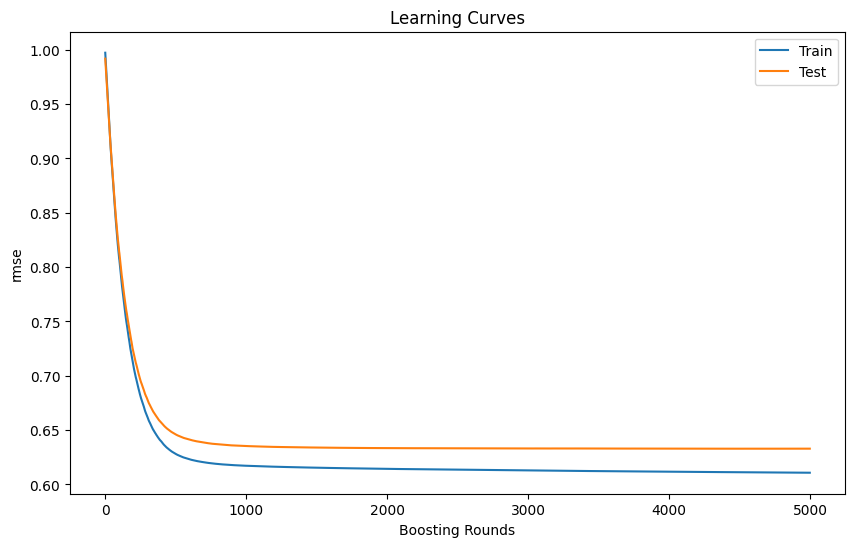

In [32]:
import matplotlib.pyplot as plt

results = xgb_model.evals_result()
train_errors = results['validation_0']['rmse']
test_errors = results['validation_1']['rmse']

plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train')
plt.plot(test_errors, label='Test')
plt.xlabel('Boosting Rounds')
plt.ylabel("rmse")
plt.legend()
plt.title('Learning Curves')
plt.show()

In [33]:
y_pred = xgb_model.predict(X_test)

In [41]:
X_test

,time_diff,cog,sog,rot,heading,latitude,longitude
545442,-0.068093,-0.442030,-0.829850,-0.023516,1.228941,0.208572,0.279065
545597,-0.072629,-0.442030,-0.829850,-0.023516,1.228941,0.208572,0.279065
545783,-0.071187,-0.442030,-0.829850,-0.023516,1.228941,0.208572,0.279065
546188,-0.062589,-0.442030,-0.829850,-0.023516,1.228941,0.208572,0.279065
546323,-0.082120,-0.442030,-0.829850,-0.023516,1.219587,0.208579,0.279065
...,...,...,...,...,...,...,...
1521048,-0.063993,1.108278,1.142370,0.152715,1.135398,1.000174,0.166931
1521244,-0.057293,1.367439,0.981372,-0.141003,1.387964,1.002531,0.165396
1521409,-0.064107,1.368372,0.954539,-0.199746,1.397318,1.005154,0.164121
1521625,-0.064259,1.669484,0.806958,-0.082259,1.659238,1.008007,0.164276


In [39]:
y_test

,time_diff,cog,sog,rot,heading,latitude,longitude
545597,-0.072629,-0.442030,-0.829850,-0.023516,1.228941,0.208572,0.279065
545783,-0.071187,-0.442030,-0.829850,-0.023516,1.228941,0.208572,0.279065
546188,-0.062589,-0.442030,-0.829850,-0.023516,1.228941,0.208572,0.279065
546323,-0.082120,-0.442030,-0.829850,-0.023516,1.219587,0.208579,0.279065
546588,-0.063898,-0.442030,-0.829850,-0.023516,1.219587,0.208572,0.279065
...,...,...,...,...,...,...,...
1521244,-0.057293,1.367439,0.981372,-0.141003,1.387964,1.002531,0.165396
1521409,-0.064107,1.368372,0.954539,-0.199746,1.397318,1.005154,0.164121
1521625,-0.064259,1.669484,0.806958,-0.082259,1.659238,1.008007,0.164276
1521821,-0.064791,-1.163580,1.491198,0.152715,-1.184463,1.010915,0.164724


In [47]:
len_test = len(y_test)
len_test

304276

In [83]:
df_y = y.iloc[-len_test:]

In [97]:
vessel_id = df_y["vesselId"].unique()[11]
print("vesselId:", vessel_id)
df_y_ = df_y[df_y["vesselId"]==vessel_id]
y_test_plot = y_test[:len(df_y_)]
y_pred_plot = pd.DataFrame(y_pred[:len(df_y_)], columns=y_test.columns)

vesselId: 61e9f469b937134a3c4c0297


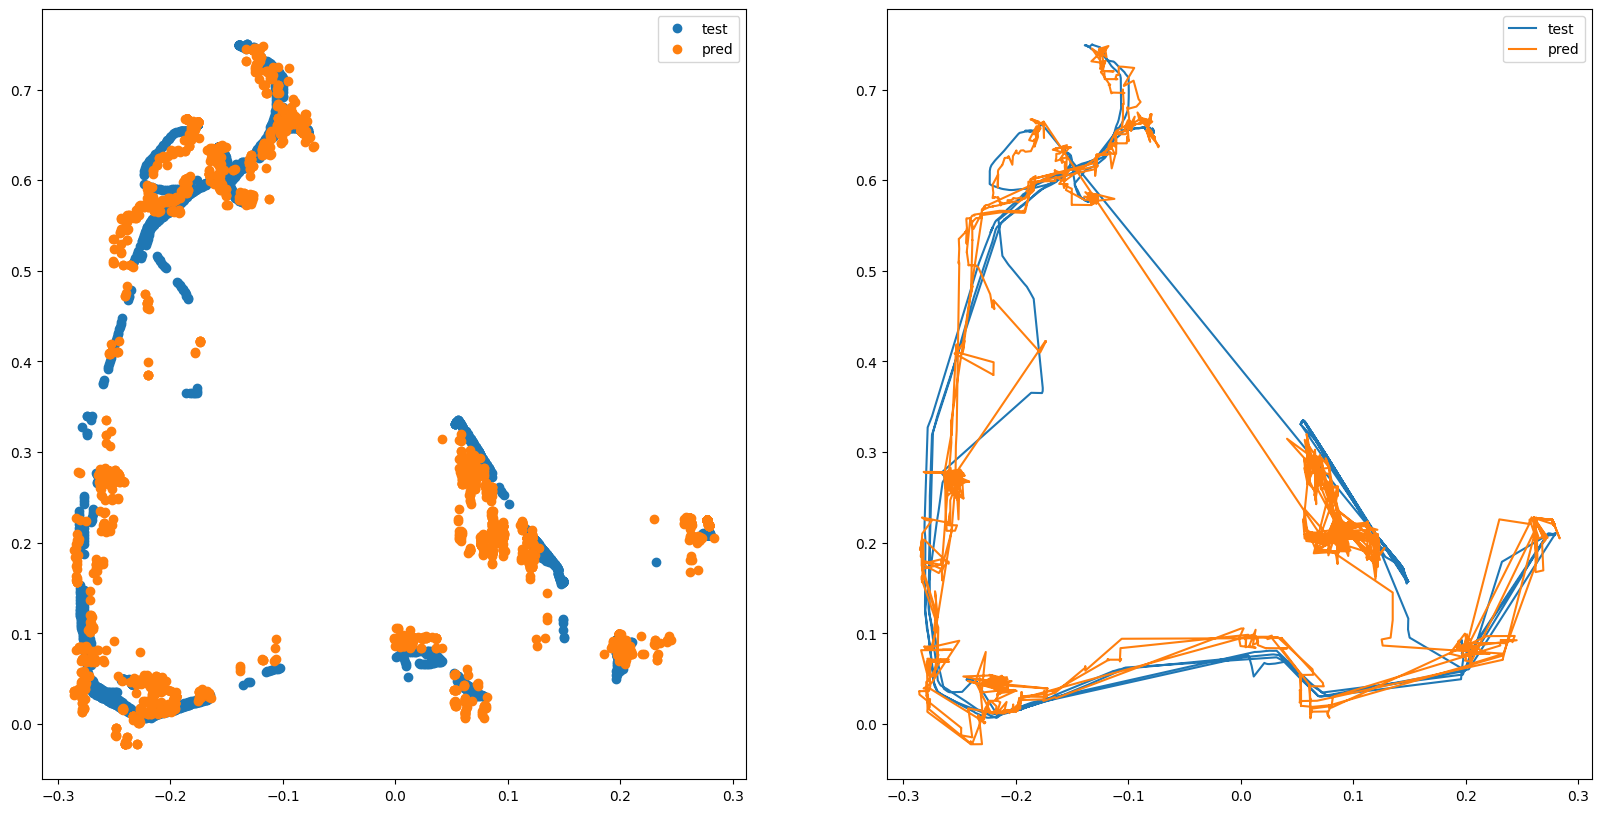

In [98]:
# vessel_id = y_test.values
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(y_test_plot["longitude"], y_test_plot["latitude"], 'o', label="test")
plt.plot(y_pred_plot["longitude"], y_pred_plot["latitude"], 'o', label="pred")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(y_test_plot["longitude"], y_test_plot["latitude"], label="test")
plt.plot(y_pred_plot["longitude"], y_pred_plot["latitude"], label="pred")
plt.legend()


vesselId: clh6aqawa0007gh0z9h6zi9bo


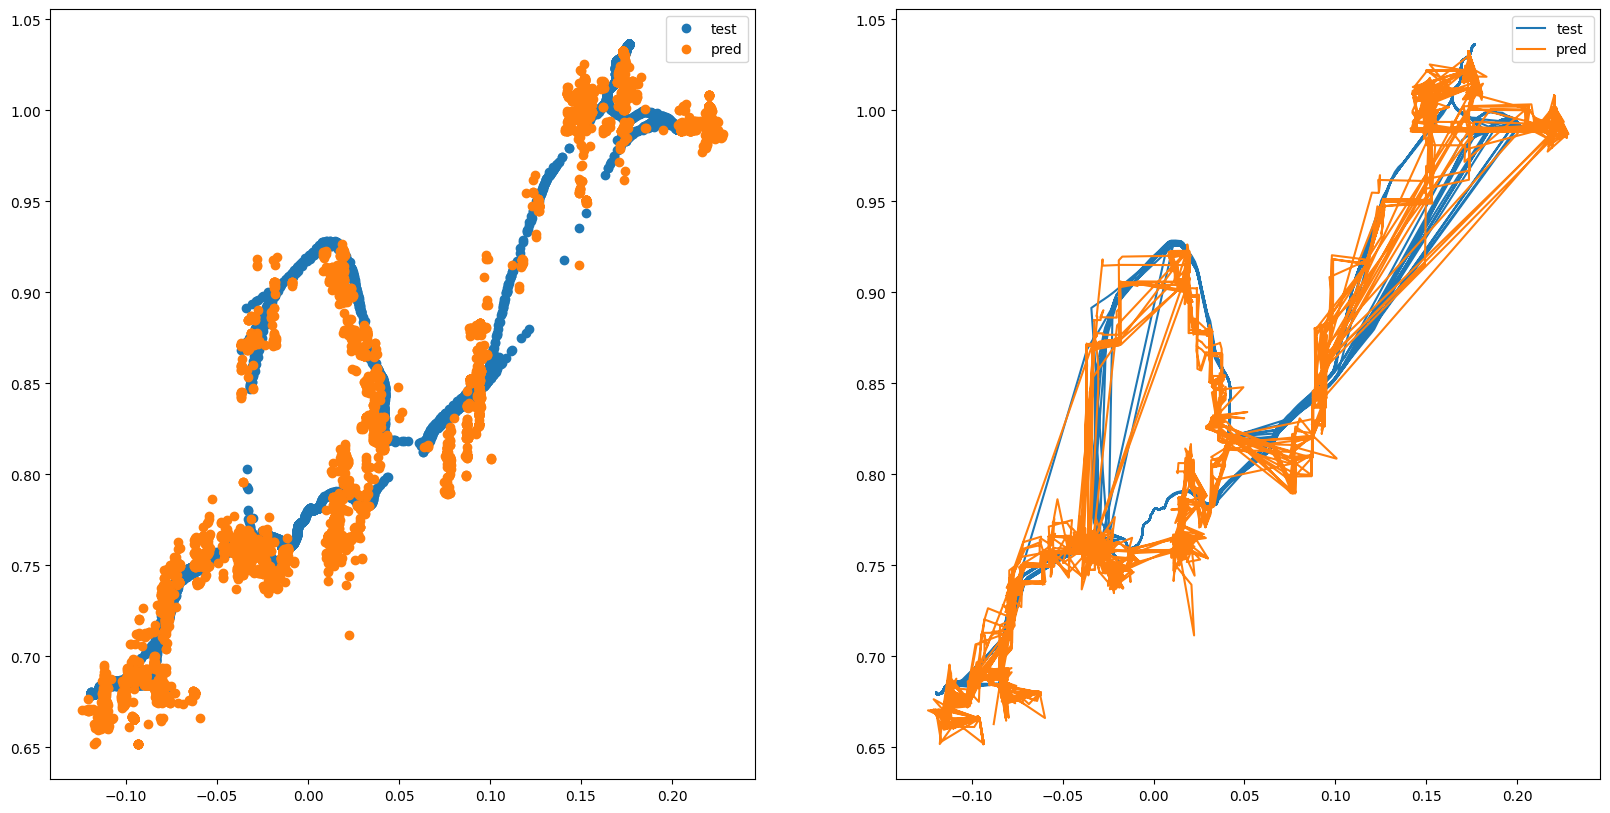

In [146]:
df_y = y.iloc[-len_test:].copy()
df_y = df_y.reset_index()
vessel_id = df_y["vesselId"].unique()[104]
print("vesselId:", vessel_id)
index = list(df_y[df_y["vesselId"]==vessel_id].index)

y_test_plot = y_test.reset_index().iloc[index]
y_pred_plot = pd.DataFrame(y_pred.take(index, axis=0), columns=y_test.columns)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(y_test_plot["longitude"], y_test_plot["latitude"], 'o', label="test")
plt.plot(y_pred_plot["longitude"], y_pred_plot["latitude"], 'o', label="pred")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(y_test_plot["longitude"], y_test_plot["latitude"], label="test")
plt.plot(y_pred_plot["longitude"], y_pred_plot["latitude"], label="pred")
plt.legend()

In [136]:

# vessel_id = y_test.values

In [ ]:
# from src.eval.metric import *

# score(y_test[["ID", "latitude", "longitude"]], y_pred, "ID")

In [147]:

def iterative_forecast(last_known, model, steps, sequence_length):
    predicted = []
    current_sequence = last_known[-sequence_length:]

    for _ in range(steps):
        # next_pred = model.predict(current_sequence.reshape(1, sequence_length, -1))[0]
        next_pred = model.predict(current_sequence)[0]
        predicted.append(next_pred)
        
        # Update current_sequence by appending next prediction
        current_sequence = np.append(current_sequence[1:], [next_pred], axis=0)
    
    return predicted

In [148]:
grouped_test = data_test.groupby("vesselId")

In [150]:
predictions = []
forecast_steps = 300
sequence_length = 1


for vessel_id, group in grouped_test:
    forecast_steps = len(group['time'].values)

    last_known_features = scaler.transform(group[scaled_features].values[-sequence_length:])
    future_preds = iterative_forecast(last_known_features, xgb_model, forecast_steps, sequence_length)
    
    # Store the predictions
    nb_preds = len(group['time'].values)
    df_pred = pd.DataFrame(scaler.inverse_transform(future_preds), columns=scaled_features)
    df_pred['time'] = group['time'].values
    df_pred["vesselId"] = vessel_id
    predictions.append(df_pred)


/Users/arthurtestard/envs/ntnu/aitask3/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/arthurtestard/envs/ntnu/aitask3/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/arthurtestard/envs/ntnu/aitask3/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/arthurtestard/envs/ntnu/aitask3/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/arthurtestard/envs/ntnu/aitask3/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with featur

In [151]:
df_preds = pd.concat(predictions, ignore_index=True)

In [152]:
res = pd.merge(ais_test, df_preds[["vesselId","time", "latitude", "longitude"]],on=["time", "vesselId"], how="left")

In [153]:
res["longitude_predicted"] = res["longitude"]
res["latitude_predicted"] = res["latitude"]
# res["id"] = res["ID"]
res = res.drop(columns=["longitude", "latitude"])

In [ ]:
res[["ID","longitude_predicted","latitude_predicted"]]

In [154]:
from utils import *

from settings import *

from datetime import datetime
import uuid

import pandas as pd

def make_file_name() -> str:
    file_name = str(uuid.uuid4()) + ".csv"
    print(f"Submission file name is: {file_name}")
    return file_name

def submit(forecast: pd.DataFrame, file_name: str = None) -> None:
    sample_submission = pd.read_csv(AIS_SAMPLE_SUBMISSION)
    file_name = file_name if file_name else make_file_name()

    repertory = SUBMISSION_FODLER.joinpath(file_name)
    sample_submission = sample_submission[['ID']].merge(forecast[["ID","longitude_predicted","latitude_predicted"]], on='ID', how='left')
    try:
        sample_submission.to_csv(repertory, index=False)
    except:
        print("Error register file")
        submit(forecast)

submit(res)

Submission file name is: 7e671c85-920f-447c-832b-be31faef7c6c.csv


In [ ]:
res["longitude_predicted"].plot()

In [ ]:
y_test["longitude"].plot()